In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import random
from tqdm import tqdm
import cv2 as cv
import PIL
from PIL import Image
!pip install plotly
import plotly.express as px
from IPython import display

import tensorflow as tf
from tensorflow import keras

import torch
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# Если вы скачали набор данных прямо на ваш компьютер, 
# то пропишите путь до # папки и файлов соответственно
base_dir = '/kaggle/input/cryptopunks/'
os.listdir(base_dir)

['txn_history-2021-10-07.jsonl', 'imgs']

In [3]:
data_dir = '../input/cryptopunks/txn_history-2021-10-07.jsonl'
image_dir = "../input/cryptopunks/imgs/imgs"
image_root = "../input/cryptopunks/imgs"

In [4]:
df = pd.read_json(base_dir + 'txn_history-2021-10-07.jsonl', lines=True)
df.head()

,txn_type,from,to,date,timestamp,source,eth,punk_id,from_wallet_address,to_wallet_address,type,accessories
0,Bid Withdrawn,0xe73a1d,,2021-09-04,2021-09-04,larvalabs,321.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
1,Bid,0xe73a1d,,2021-09-01,2021-09-01,larvalabs,321.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
2,Bid Withdrawn,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,320.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
3,Bid,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,320.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
4,Bid Withdrawn,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,263.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"


Sample 100 CryptoPunks


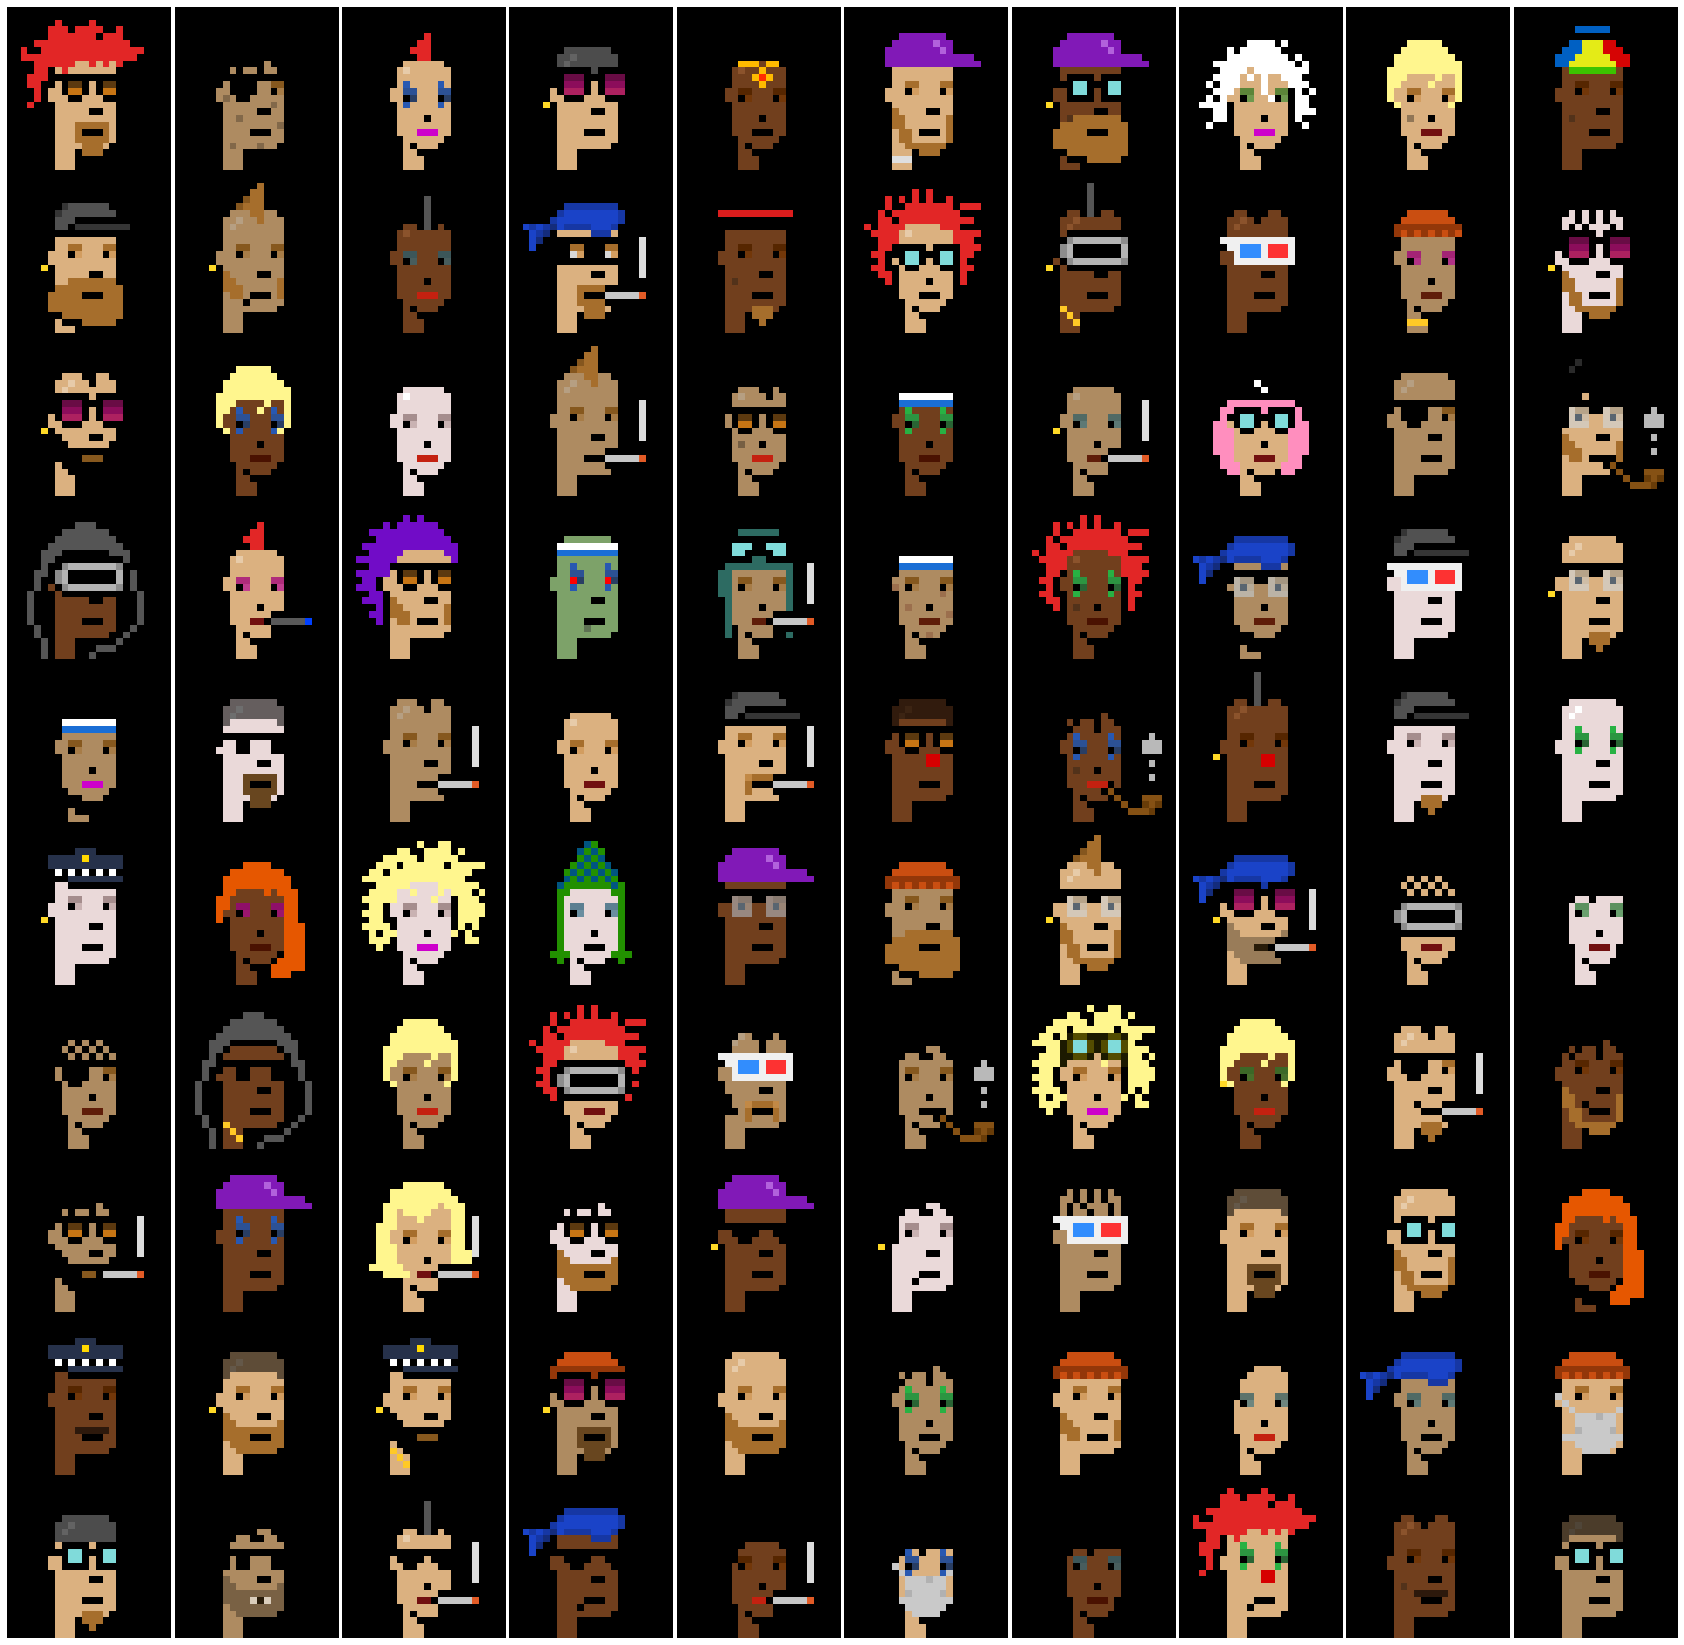

In [5]:
no_plots = 10*10

# путь до картинок
images = glob.glob("../input/cryptopunks/imgs/imgs/*.png")

plt.rcParams['figure.figsize'] = (30, 30)
plt.subplots_adjust(wspace=0, hspace=0)

print("Sample 100 CryptoPunks")
for idx, image in enumerate(images[:no_plots]):
    sample_img = cv.imread(image)
    plt.subplot(10, 10, idx+1)
    plt.axis('off')
    plt.imshow(cv.cvtColor(sample_img,cv.COLOR_BGR2RGB)) #covert color space
plt.show()

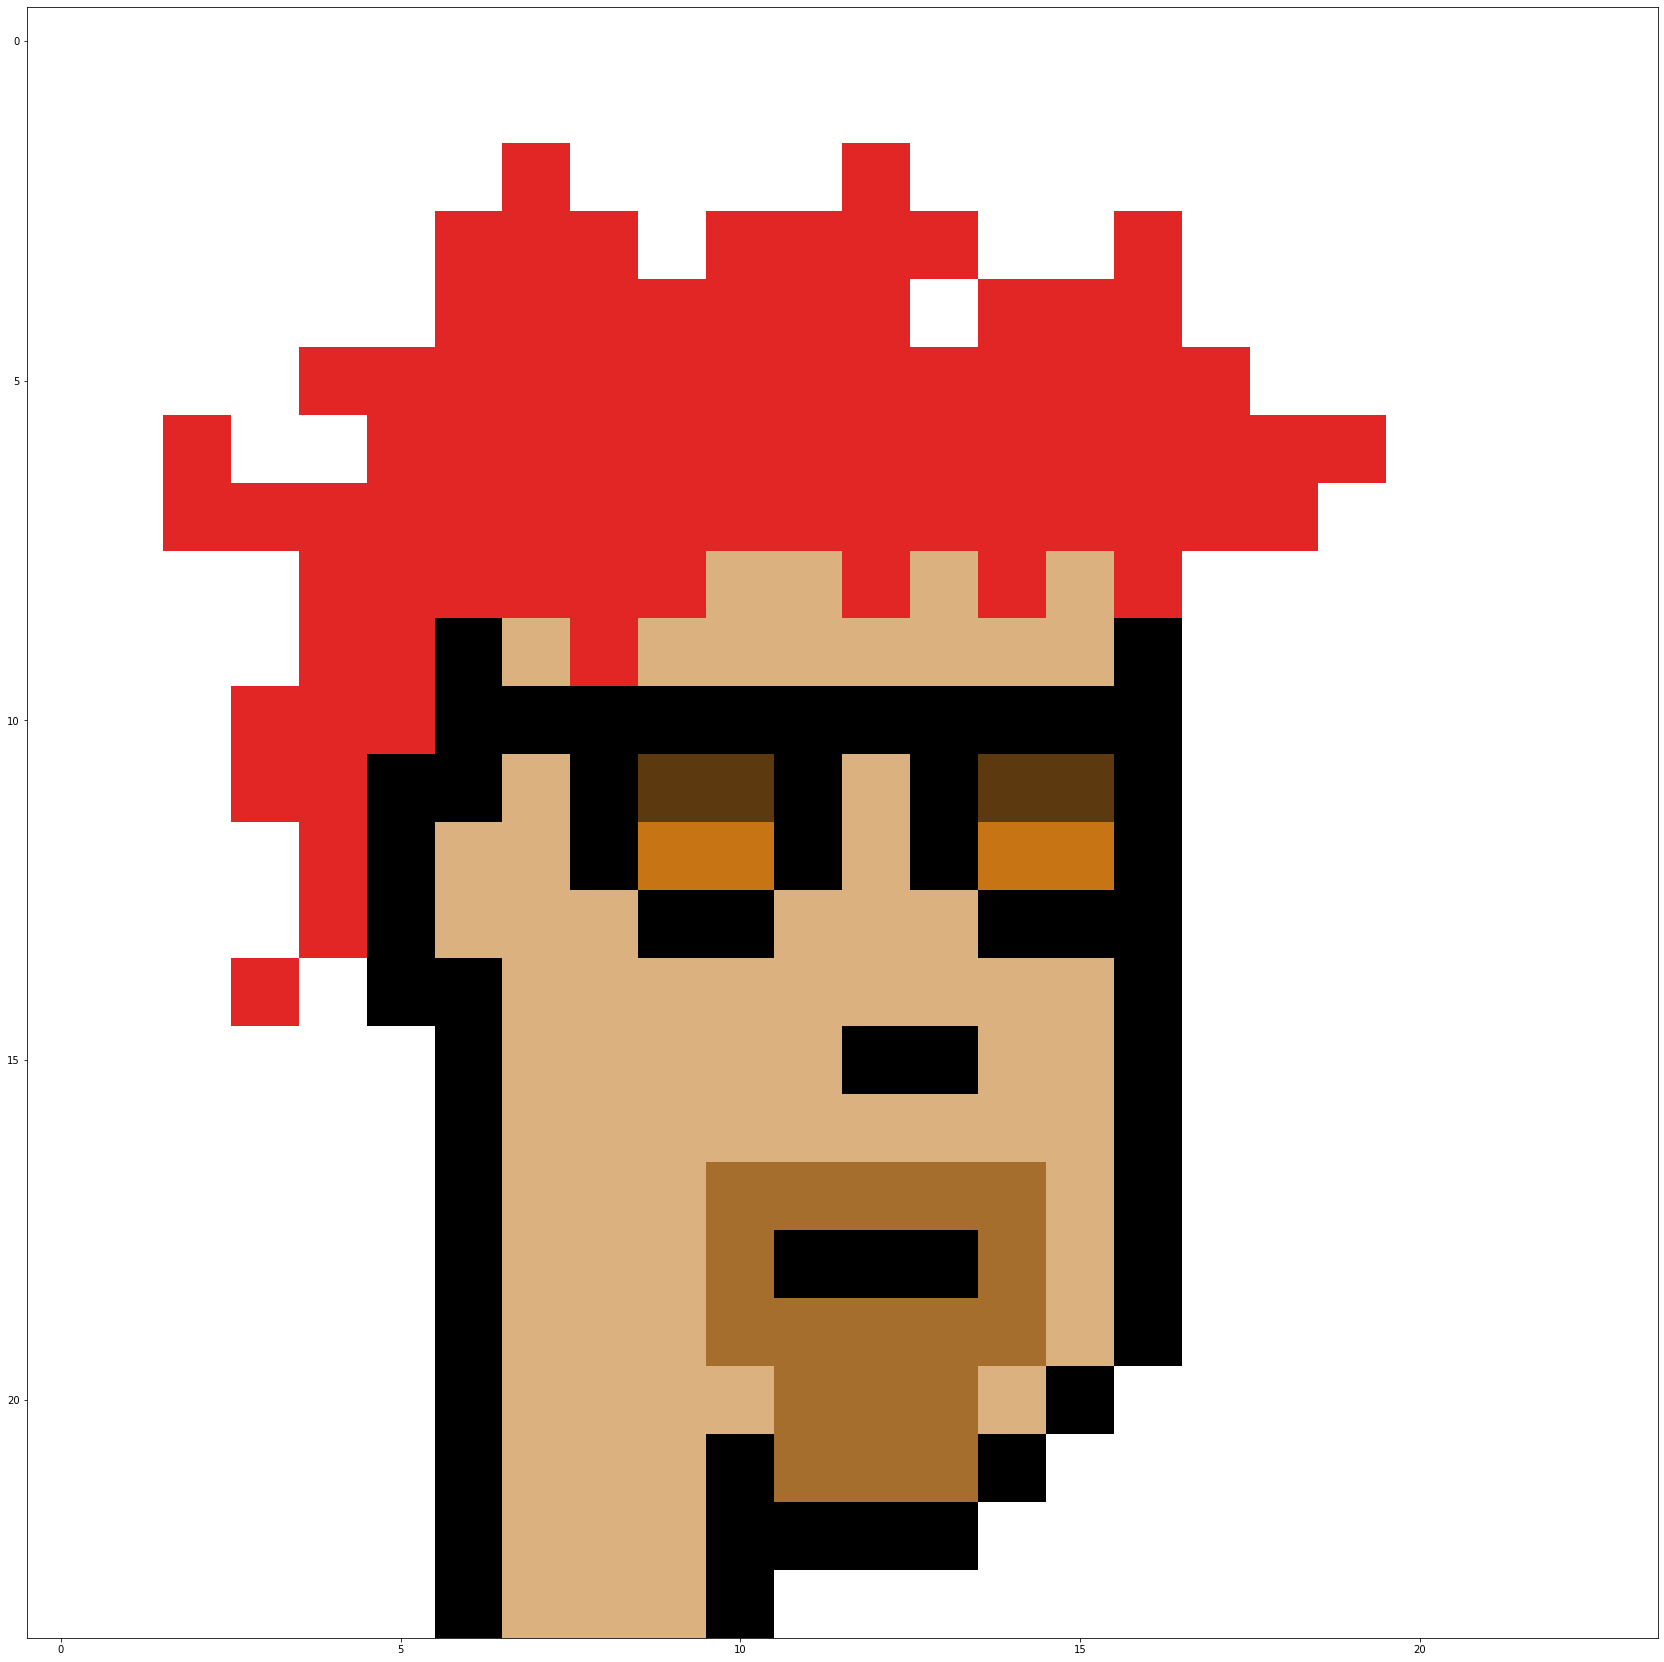

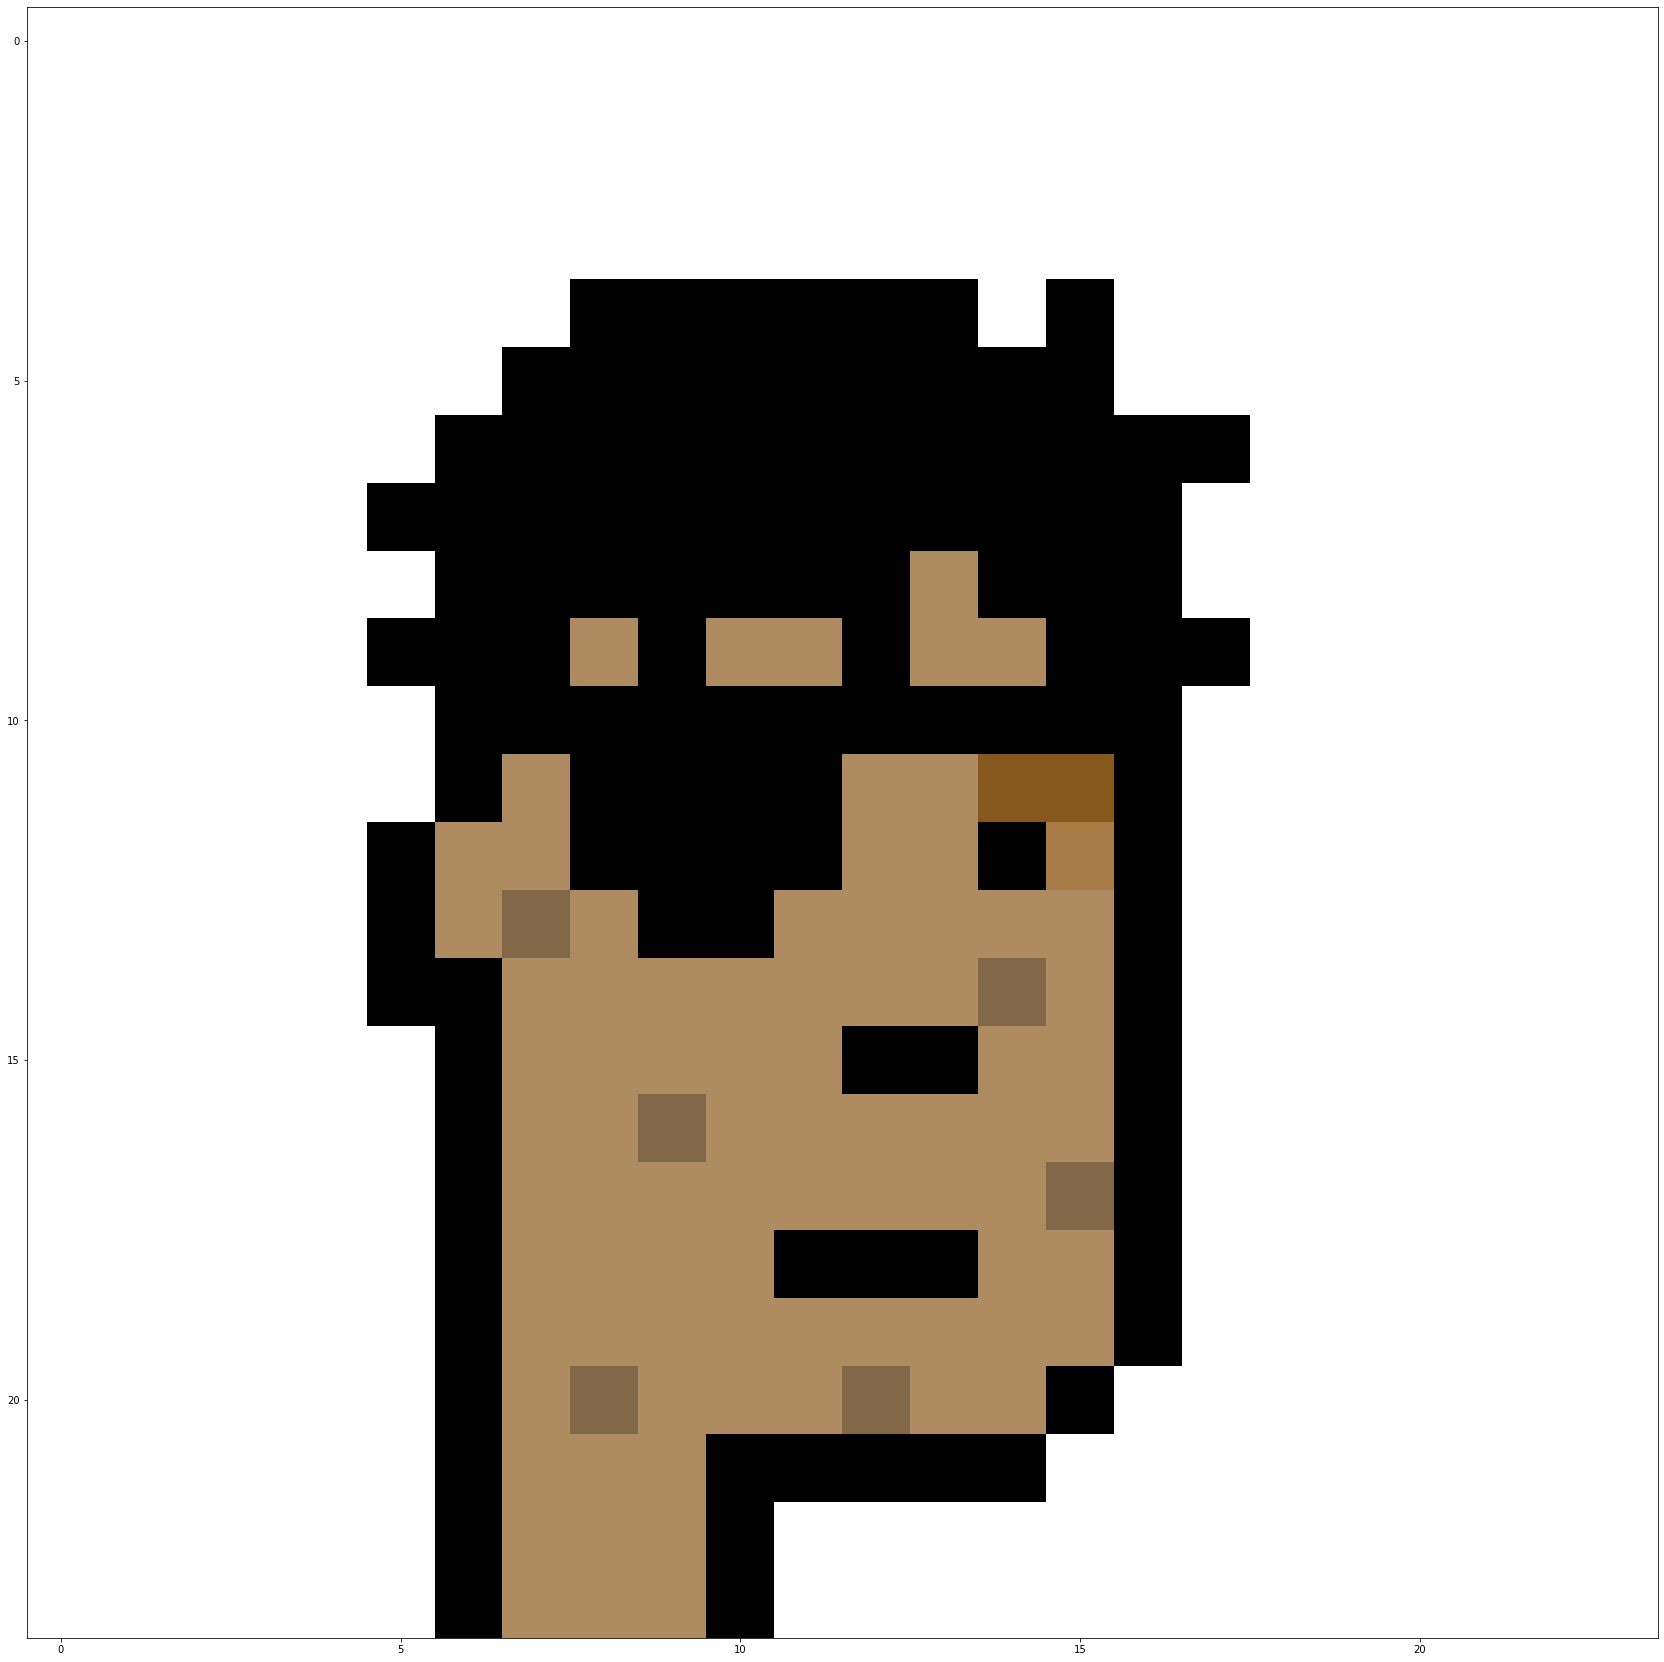

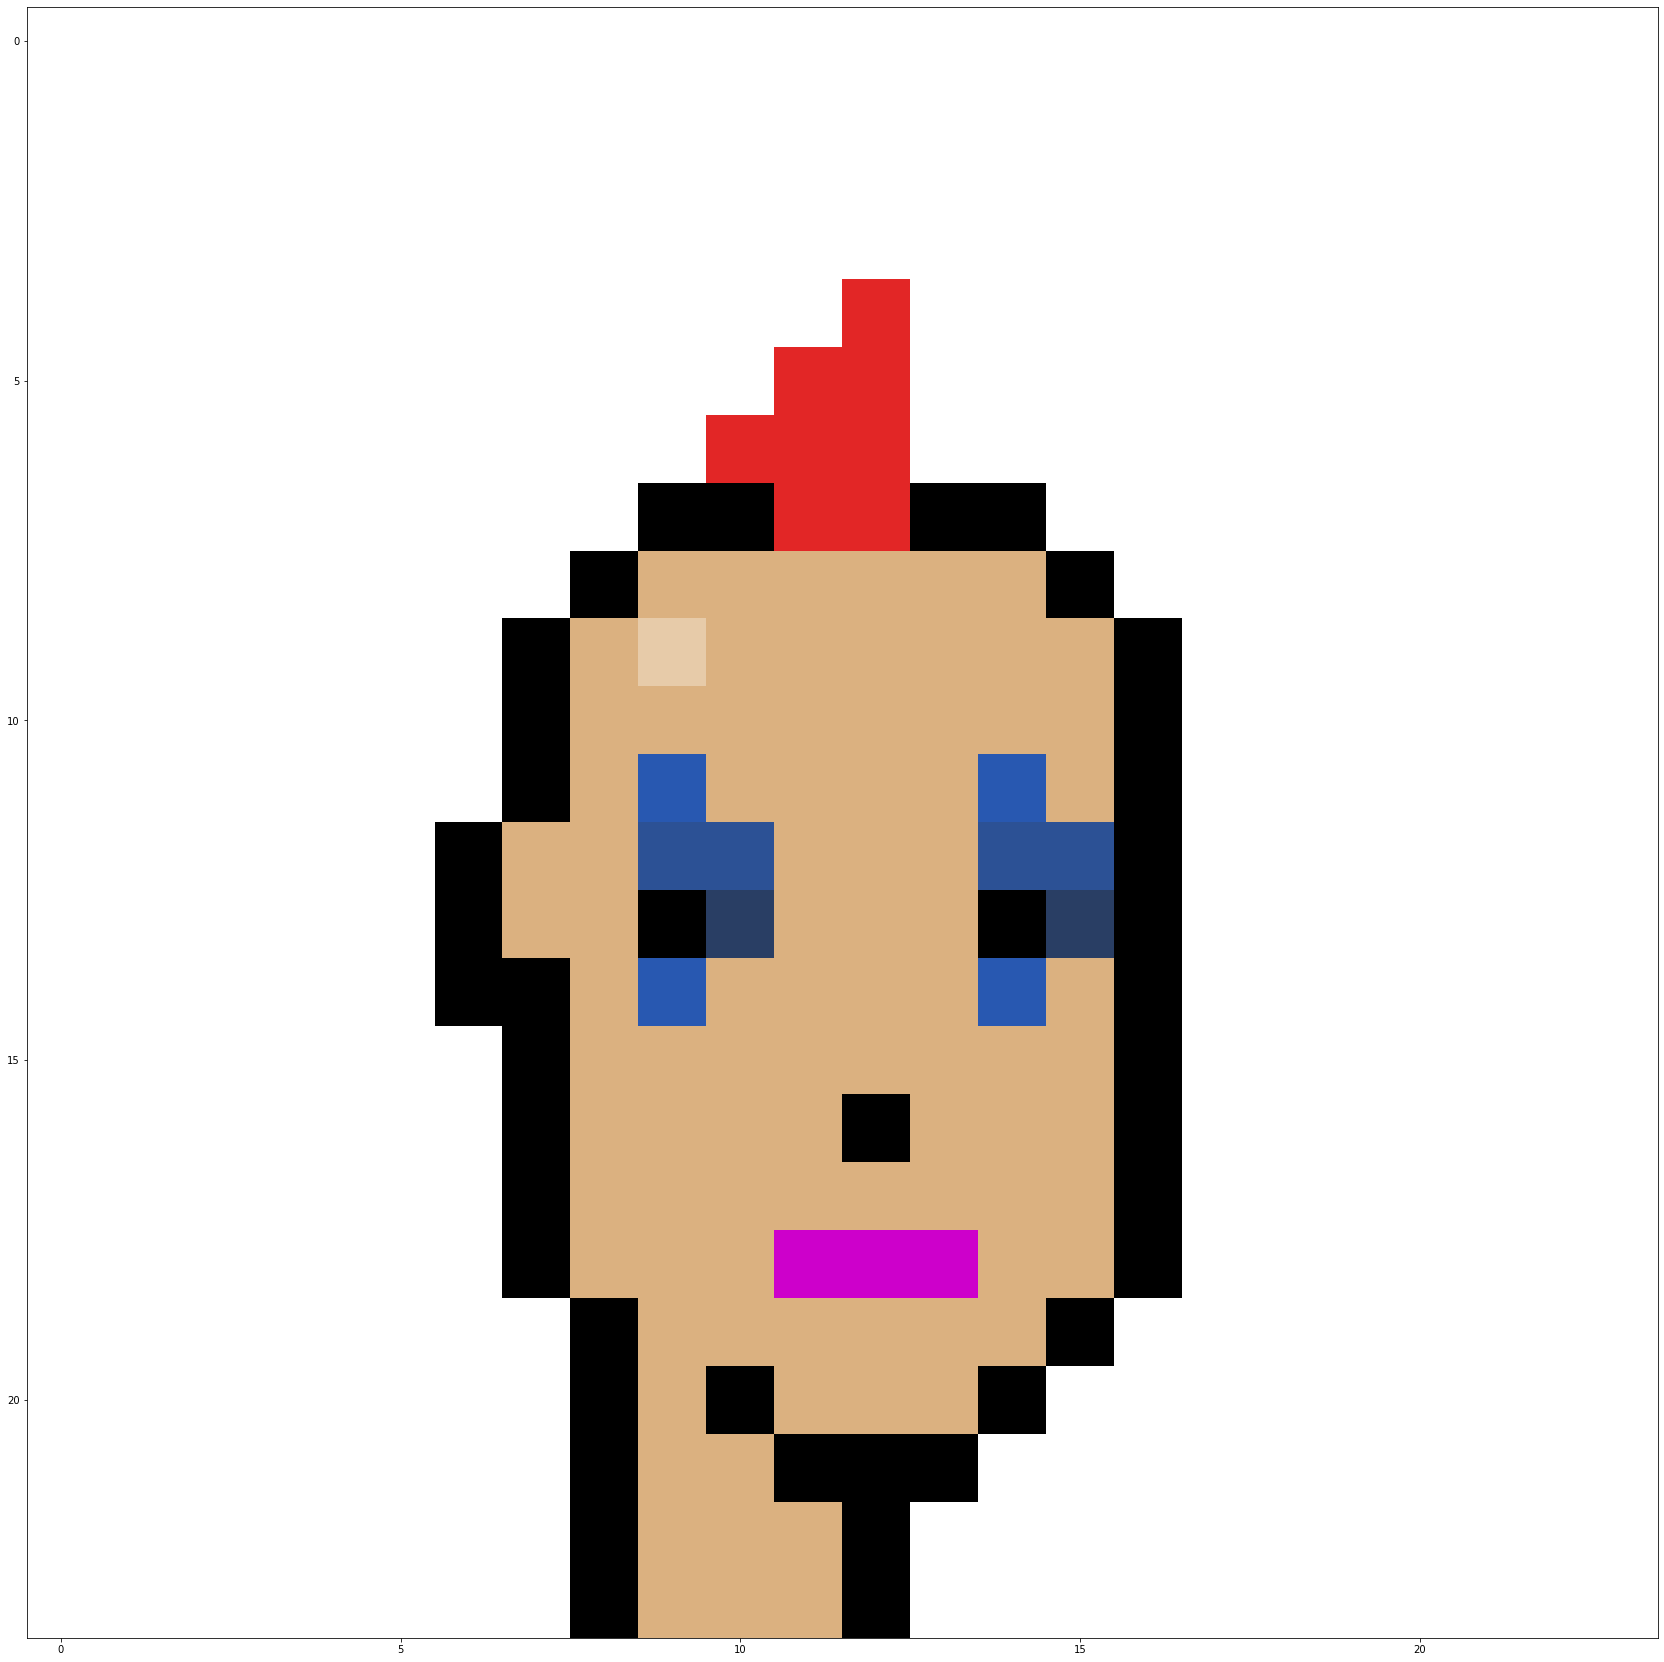

In [6]:
# Пример нескольких панков
punks = [img for img in glob.glob("../input/cryptopunks/imgs/imgs/*.png")]

for punk in punks[0:3]:
    img = plt.imread(punk)
    plt.imshow(img)
    plt.show()

In [8]:
df = df[["txn_type", "date", "eth", "punk_id", "type", "accessories"]]
df.head()

,txn_type,date,eth,punk_id,type,accessories
0,Bid Withdrawn,2021-09-04,321.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
1,Bid,2021-09-01,321.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
2,Bid Withdrawn,2021-09-01,320.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
3,Bid,2021-09-01,320.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
4,Bid Withdrawn,2021-09-01,263.0,0,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"


In [13]:
# визуализация
fig = px.bar(df[df.txn_type == 'Sold'].groupby("type").agg({"eth": "max"}).sort_values(by="eth").reset_index('type'),
             x="type", 
             y="eth", 
             color="type", 
             title="Виды CryptoPunk по отношению к цене")
fig.show()

## Необходимые функции

In [20]:
# отображение изображений
def tensor_imshow(img, dnorm=True):
    img = img.to('cpu')
    npimg = img.detach().numpy()
    if dnorm:
        npimg = npimg * 0.5 + 0.5
    plt.figure(figsize=(3, 3))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [21]:
def get_dataloader(batch_size,         
                   image_size,    
                   data_dir=image_dir,   
                   num_workers=3):
    
    stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) 
    
    # трансформер для изменения картинок в подходящий формат
    transform = transforms.Compose([transforms.Resize((image_size, image_size)),  #размер
                                    transforms.ToTensor(),                        # конвертируем
                                    transforms.Normalize(*stats)])                #нормализация между -1 и 1
    
    # создаем датасет
    dataset = datasets.ImageFolder(root=data_dir,
                                   transform=transform)
    
    # создаем загрузчик данных
    data_loader = torch.utils.data.DataLoader(dataset,
                                              batch_size=batch_size, shuffle=True,num_workers=num_workers, pin_memory=True)
    
    return data_loader

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning:

This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



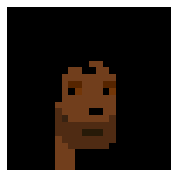

In [22]:
# тестируем загрузчик
batch_size, image_size = 5, 24

train_loader = get_dataloader(batch_size,
                              image_size,
                              image_root)

dataiter = iter(train_loader) # это итератор

img,_ = next(dataiter)
sample_img = img[-1]

tensor_imshow(sample_img)

## Код генератора

In [23]:
class Generator(nn.Module):
    def __init__(self, 
                 z_dim=100,      # шумовой вектор
                 im_chan=3,      # канал цвета, 3 для красного, зеленого и синего
                 hidden_dim=64): # размерность
        
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.im_chan = im_chan
        self.hidden_dim = hidden_dim
        
        self.generator_cnn = nn.Sequential(self.make_gen_block(z_dim, hidden_dim*8, stride=1, padding=0),   
                                           #(64*8) x 4 x 4
                                           self.make_gen_block(hidden_dim*8, hidden_dim*4),                           
                                           #(64*4) x 8 x 8
                                           self.make_gen_block(hidden_dim*4, hidden_dim*2),                           
                                           #(64*2) x 16 x 16
                                           self.make_gen_block(hidden_dim*2, hidden_dim),                             
                                           #(64) x 32 x 32
                                           self.make_gen_block(hidden_dim, im_chan, final_layer=True))
    
    def make_gen_block(self, 
                       im_chan,    
                       op_chan,     
                       kernel_size=4, 
                       stride=2, 
                       padding=1, 
                       final_layer=False): 
        
        layers = []
        layers.append(nn.ConvTranspose2d(im_chan,     
                                         op_chan, 
                                         kernel_size, 
                                         stride, 
                                         padding, 
                                         bias=False))
        
        if not final_layer:
            layers.append(nn.BatchNorm2d(op_chan))
            layers.append(nn.LeakyReLU(0.2))
        else:
            layers.append(nn.Tanh())
        
        return nn.Sequential(*layers)
    
    def forward(self,noise):
        x = noise.view(-1,self.z_dim,1,1)
        return self.generator_cnn(x)

    def get_noise(n_samples, 
                  z_dim, 
                  device='cpu'):
        return torch.randn(n_samples, 
                           z_dim, 
                           device=device)

In [25]:
# тестируем Генератор
noise = Generator.get_noise(n_samples=5,
                            z_dim=100)

g = Generator(z_dim=100,
              im_chan=3,
              hidden_dim=64)
print(g)

Generator(
  (generator_cnn): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

## Код дискриминатора

In [26]:
class Discriminator(nn.Module):
    def __init__(self, 
                 im_chan=3,       # канал цвета, 3 для красного, зеленого и синего
                 conv_dim=64,     # размерность
                 image_size=64):  # размер картинок для тренировки
        
        super(Discriminator, self).__init__()
        self.image_size = image_size
        self.conv_dim = conv_dim
        
        self.disc_cnn = nn.Sequential(self.make_disc_block(im_chan, conv_dim),
                                      self.make_disc_block(conv_dim, conv_dim*2),
                                      self.make_disc_block(conv_dim*2, conv_dim*4),
                                      self.make_disc_block(conv_dim*4, conv_dim*8),
                                      # сигмоид здесь не нужен, так как он включен в функцию потерь loss
                                      self.make_disc_block(conv_dim*8, 1, padding=0, final_layer=True)) 
   def make_disc_block(self,
                        im_chan,
                        op_chan,
                        kernel_size=4,
                        stride=2,
                        padding=1,
                        final_layer=False):
        layers = []
        layers.append(nn.Conv2d(im_chan,
                                op_chan,
                                kernel_size,
                                stride,
                                padding,
                                bias=False))

        
        if not final_layer:
            layers.append(nn.BatchNorm2d(op_chan))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        return nn.Sequential(*layers)
    
    # функции для возврата одноразмерного тензора

    def forward(self,image):
        pred = self.disc_cnn(image)
        pred = pred.view(image.size(0),-1)
        return pred
    
    def _get_final_feature_dimention(self):
        final_width_height = (self.image_size //  2**len(self.disc_cnn))**2
        final_depth = self.conv_dim * 2**(len(self.disc_cnn)-1)
        return final_depth*final_width_height

In [28]:
# тестируем Дискриминатор
d = Discriminator(im_chan=3,
                  conv_dim=64,
                  image_size=64)
print(d)

Discriminator(
  (disc_cnn): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affi

## Параметры для модели


In [29]:
def weights_init_normal(m):
    
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weights, 0.0, 0.02)
    
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weights, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

### Функция потерь

In [30]:
def real_loss(D_out,device='cpu'): # вы можете указать GPU при наличии у вас видеокарты
                                                             # или если вы пишете код прямо на  Kaggle
   
    criterion = nn.BCEWithLogitsLoss()
	batch_size = D_out.size(0)
	labels = torch.ones(batch_size, device=device)*0.9
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out, device='cpu'):

    criterion = nn.BCEWithLogitsLoss()
	batch_size = D_out.size(0)
    labels = torch.zeros(batch_size,
                         device=device) 
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Тренировка модели

In [32]:
def print_tensor_images(images_tensor):
    
    '''
    Функция для отображения изображений: даем тензор, получаем картинку.
    '''
        
    plt.rcParams['figure.figsize'] = (15, 15)
    plt.subplots_adjust(wspace=0, hspace=0)
    
    images_tensor = images_tensor.to('cpu')
    npimgs = images_tensor.detach().numpy()
    
    no_plots = len(images_tensor)

    for idx,image in enumerate(npimgs):
        plt.subplot(1, 8, idx+1)
        plt.axis('off')
        #dnorm
        image = image * 0.5 + 0.5
        plt.imshow(np.transpose(image, (1, 2, 0)))
        
    plt.show()

In [33]:
def train(D, G, 
          n_epochs,
          dataloader,
          d_optimizer,
          g_optimizer,
          z_dim,
          print_every=50,
          device='cpu'): # gpu при необходимости
    
   sample_size=8
    fixed_z = Generator.get_noise(n_samples=sample_size,
                                  z_dim=z_dim,
                                  device=device)
    
    for epoch in range(1,n_epochs+1):
        for batch_i,(real_images,_) in enumerate(dataloader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)
            
            # Часть1: тренируем дискриминатор
            d_optimizer.zero_grad()
            d_real_op = D(real_images)
            d_real_loss = real_loss(d_real_op,
                                    device=device)
            noise = Generator.get_noise(n_samples=batch_size,
                                        z_dim=z_dim,
                                        device=device)
            fake_images = G(noise)
            d_fake_op = D(fake_images)
            d_fake_loss = fake_loss(d_fake_op,
                                    device=device)
            d_loss = d_real_loss + d_fake_loss

 

            d_loss.backward()
            d_optimizer.step()
            
            # Часть 2: тренируем генератор
            g_optimizer.zero_grad()
            noise = Generator.get_noise(n_samples=batch_size,
                                        z_dim=z_dim,
                                        device=device)
            g_out = G(noise)
            d_out = D(g_out)
            
            g_loss = real_loss(d_out, 
                               device=device) 
            g_loss.backward()
            g_optimizer.step()
        
        print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(epoch, 
                                                                               n_epochs, 
                                                                               d_loss.item(), 
                                                                               g_loss.item()))
        if (epoch % print_every == 0):
            G.eval()
            sample_image = G(fixed_z)
            print_tensor_images(sample_image)
            G.train()

### Тренируем модель!

In [34]:
# Гиперпараметры
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device is ", device)

z_dim = 100
beta_1 = 0.5 
beta_2 = 0.999 
lr = 0.0002
n_epochs = 100
batch_size = 128
image_size = 64

Device is  cuda


In [35]:
# инициализируем генератор
generator = Generator(z_dim, 
                      im_chan=3, 
                      hidden_dim=64).to(device)

# инициализируем дискриминатор
discriminator = Discriminator(im_chan=3, 
                              conv_dim=64, 
                              image_size=image_size).to(device)

# Настраиваем Adam оптимизацию для генератора
g_optimizer = optim.Adam(generator.parameters(), 
                         lr=lr, 
                         betas=(beta_1, beta_2))

# Настраиваем Adam оптимизацию для дискриминатора
d_optimizer = optim.Adam(discriminator.parameters(), 
                         lr=lr, 
                         betas=(beta_1, beta_2))

dataloader = get_dataloader(batch_size, 
                            image_size, 
                            image_root)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.2 µs
Epoch [    1/  100] | d_loss: 0.3297 | g_loss: 6.7865
Epoch [    2/  100] | d_loss: 0.6217 | g_loss: 3.1313
Epoch [    3/  100] | d_loss: 0.6149 | g_loss: 3.6159
Epoch [    4/  100] | d_loss: 0.5860 | g_loss: 1.0440
Epoch [    5/  100] | d_loss: 0.5689 | g_loss: 3.0261
Epoch [    6/  100] | d_loss: 0.5304 | g_loss: 2.0585
Epoch [    7/  100] | d_loss: 0.3828 | g_loss: 4.5416
Epoch [    8/  100] | d_loss: 0.5006 | g_loss: 4.7493
Epoch [    9/  100] | d_loss: 0.4426 | g_loss: 3.3050
Epoch [   10/  100] | d_loss: 0.6969 | g_loss: 5.3660


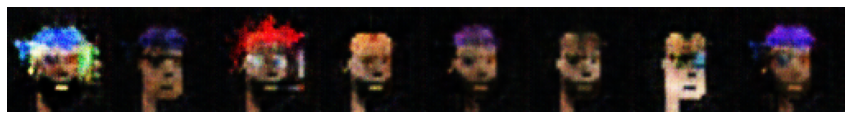

Epoch [   11/  100] | d_loss: 0.5736 | g_loss: 1.9182
Epoch [   12/  100] | d_loss: 0.5124 | g_loss: 2.2878
Epoch [   13/  100] | d_loss: 0.3637 | g_loss: 5.5494
Epoch [   14/  100] | d_loss: 0.3907 | g_loss: 3.9823
Epoch [   15/  100] | d_loss: 1.1530 | g_loss: 1.2958
Epoch [   16/  100] | d_loss: 0.4398 | g_loss: 2.1751
Epoch [   17/  100] | d_loss: 0.3503 | g_loss: 4.1707
Epoch [   18/  100] | d_loss: 0.5222 | g_loss: 3.8946
Epoch [   19/  100] | d_loss: 0.3697 | g_loss: 4.3014
Epoch [   20/  100] | d_loss: 0.5630 | g_loss: 4.5108


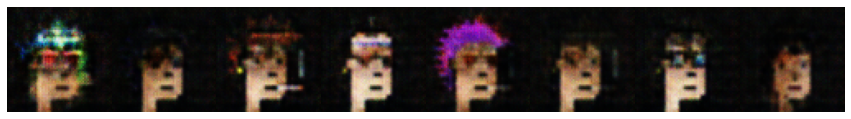

Epoch [   21/  100] | d_loss: 0.3920 | g_loss: 5.9701
Epoch [   22/  100] | d_loss: 0.4779 | g_loss: 2.9122
Epoch [   23/  100] | d_loss: 0.3450 | g_loss: 4.3853
Epoch [   24/  100] | d_loss: 0.4276 | g_loss: 7.6348
Epoch [   25/  100] | d_loss: 0.3477 | g_loss: 3.4538
Epoch [   26/  100] | d_loss: 0.3427 | g_loss: 3.4509
Epoch [   27/  100] | d_loss: 0.3443 | g_loss: 4.8122
Epoch [   28/  100] | d_loss: 0.4702 | g_loss: 2.7572
Epoch [   29/  100] | d_loss: 0.3475 | g_loss: 4.1997
Epoch [   30/  100] | d_loss: 0.3404 | g_loss: 4.8563


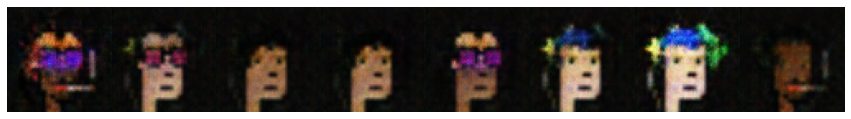

Epoch [   31/  100] | d_loss: 0.8013 | g_loss: 4.1932
Epoch [   32/  100] | d_loss: 0.8533 | g_loss: 0.4757
Epoch [   33/  100] | d_loss: 0.3606 | g_loss: 4.2181
Epoch [   34/  100] | d_loss: 0.3523 | g_loss: 8.2406
Epoch [   35/  100] | d_loss: 0.3672 | g_loss: 5.1699
Epoch [   36/  100] | d_loss: 0.4187 | g_loss: 1.9195
Epoch [   37/  100] | d_loss: 0.3451 | g_loss: 6.7526
Epoch [   38/  100] | d_loss: 0.7393 | g_loss: 1.7012
Epoch [   39/  100] | d_loss: 0.4401 | g_loss: 5.3846
Epoch [   40/  100] | d_loss: 0.3777 | g_loss: 4.0203


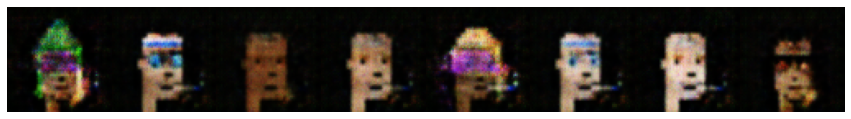

Epoch [   41/  100] | d_loss: 0.3382 | g_loss: 5.4182
Epoch [   42/  100] | d_loss: 0.3424 | g_loss: 6.8506
Epoch [   43/  100] | d_loss: 0.4328 | g_loss: 2.2150
Epoch [   44/  100] | d_loss: 0.3328 | g_loss: 5.1812
Epoch [   45/  100] | d_loss: 0.5477 | g_loss: 2.1578
Epoch [   46/  100] | d_loss: 0.7978 | g_loss: 2.0222
Epoch [   47/  100] | d_loss: 0.4934 | g_loss: 1.7453
Epoch [   48/  100] | d_loss: 0.8042 | g_loss: 0.5669
Epoch [   49/  100] | d_loss: 0.4195 | g_loss: 3.0788
Epoch [   50/  100] | d_loss: 0.4212 | g_loss: 2.8351


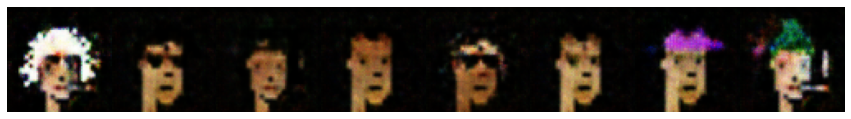

Epoch [   51/  100] | d_loss: 0.5194 | g_loss: 1.4355
Epoch [   52/  100] | d_loss: 0.4126 | g_loss: 7.0775
Epoch [   53/  100] | d_loss: 0.3771 | g_loss: 3.3333
Epoch [   54/  100] | d_loss: 1.2459 | g_loss: 0.4669
Epoch [   55/  100] | d_loss: 0.4129 | g_loss: 3.0376
Epoch [   56/  100] | d_loss: 0.4025 | g_loss: 3.9437
Epoch [   57/  100] | d_loss: 0.3522 | g_loss: 6.1967
Epoch [   58/  100] | d_loss: 0.3779 | g_loss: 6.3470
Epoch [   59/  100] | d_loss: 0.4246 | g_loss: 3.8353
Epoch [   60/  100] | d_loss: 1.0250 | g_loss: 0.6966


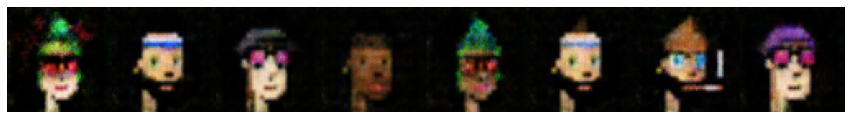

Epoch [   61/  100] | d_loss: 1.0261 | g_loss: 0.5910
Epoch [   62/  100] | d_loss: 0.3618 | g_loss: 6.3136
Epoch [   63/  100] | d_loss: 0.6643 | g_loss: 1.2034
Epoch [   64/  100] | d_loss: 0.3578 | g_loss: 4.2783
Epoch [   65/  100] | d_loss: 0.3604 | g_loss: 4.6109
Epoch [   66/  100] | d_loss: 0.3679 | g_loss: 4.1233
Epoch [   67/  100] | d_loss: 0.3858 | g_loss: 3.1894
Epoch [   68/  100] | d_loss: 0.4638 | g_loss: 5.2089
Epoch [   69/  100] | d_loss: 0.3593 | g_loss: 5.9762
Epoch [   70/  100] | d_loss: 0.4510 | g_loss: 2.1207


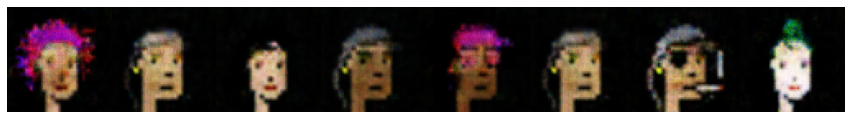

Epoch [   71/  100] | d_loss: 0.6766 | g_loss: 1.6600
Epoch [   72/  100] | d_loss: 0.4091 | g_loss: 3.8826
Epoch [   73/  100] | d_loss: 0.3409 | g_loss: 6.0357
Epoch [   74/  100] | d_loss: 0.4325 | g_loss: 3.7874
Epoch [   75/  100] | d_loss: 0.5640 | g_loss: 2.4858
Epoch [   76/  100] | d_loss: 0.3450 | g_loss: 5.0128
Epoch [   77/  100] | d_loss: 0.8649 | g_loss: 1.4313
Epoch [   78/  100] | d_loss: 0.3495 | g_loss: 3.1185
Epoch [   79/  100] | d_loss: 0.3451 | g_loss: 4.3006
Epoch [   80/  100] | d_loss: 0.3547 | g_loss: 3.3373


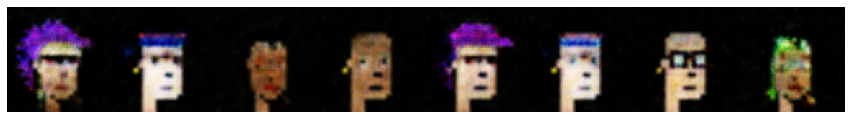

Epoch [   81/  100] | d_loss: 0.7819 | g_loss: 0.8054
Epoch [   82/  100] | d_loss: 0.3741 | g_loss: 5.4299
Epoch [   83/  100] | d_loss: 0.8508 | g_loss: 1.6979
Epoch [   84/  100] | d_loss: 0.5371 | g_loss: 2.9842
Epoch [   85/  100] | d_loss: 0.3579 | g_loss: 4.1340
Epoch [   86/  100] | d_loss: 0.3431 | g_loss: 4.6247
Epoch [   87/  100] | d_loss: 0.3322 | g_loss: 5.8959
Epoch [   88/  100] | d_loss: 0.6843 | g_loss: 2.9684
Epoch [   89/  100] | d_loss: 0.9217 | g_loss: 0.6483
Epoch [   90/  100] | d_loss: 0.3956 | g_loss: 3.1115


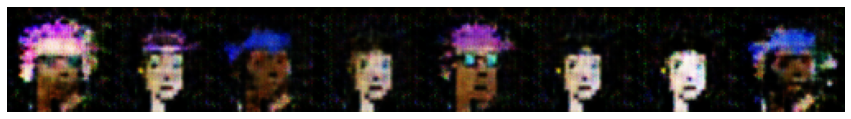

Epoch [   91/  100] | d_loss: 0.4770 | g_loss: 4.2149
Epoch [   92/  100] | d_loss: 0.4139 | g_loss: 3.2766
Epoch [   93/  100] | d_loss: 1.3343 | g_loss: 0.6644
Epoch [   94/  100] | d_loss: 0.3621 | g_loss: 5.5324
Epoch [   95/  100] | d_loss: 0.3379 | g_loss: 5.2795
Epoch [   96/  100] | d_loss: 2.4501 | g_loss: 0.8048
Epoch [   97/  100] | d_loss: 0.4728 | g_loss: 1.4067
Epoch [   98/  100] | d_loss: 0.6987 | g_loss: 0.8361
Epoch [   99/  100] | d_loss: 0.5604 | g_loss: 1.8246
Epoch [  100/  100] | d_loss: 0.4023 | g_loss: 3.5132


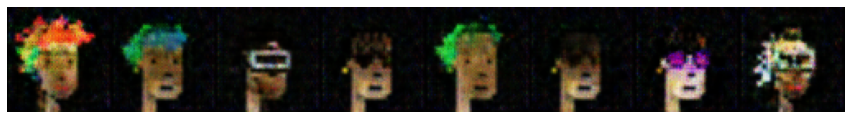

In [36]:
# начинаем тренировку!
%time
n_epochs = 100
train(discriminator,
      generator,
      n_epochs,
      dataloader,
      d_optimizer,
      g_optimizer,
      z_dim,
      print_every=10,
      device=device)

In [38]:
def save_model(generator,file_name):
    generator = generator.to('cuda')
    torch.save(generator.state_dict(),"cryptopunks_generator.pth")

save_model(generator,"kaggle")

## Генерируем новых криптопанков

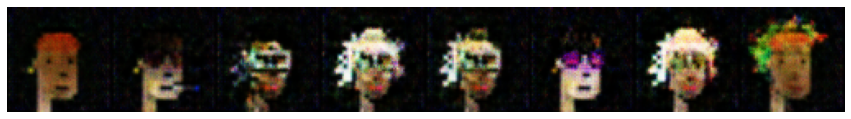

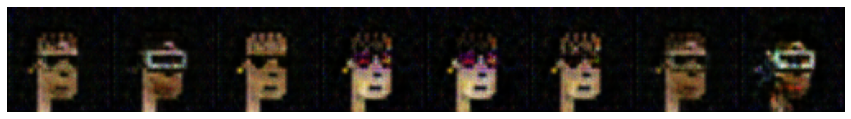

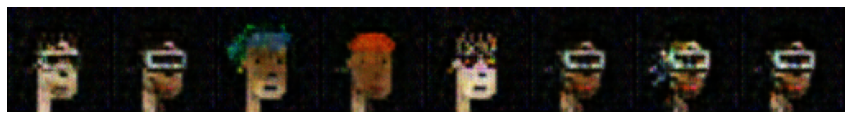

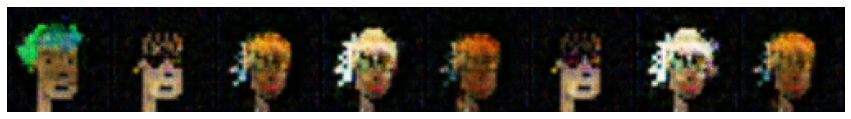

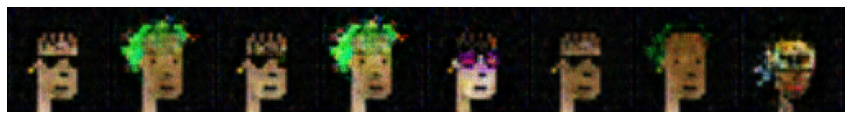

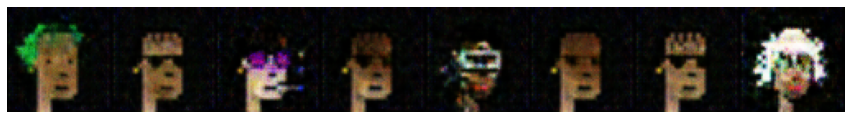

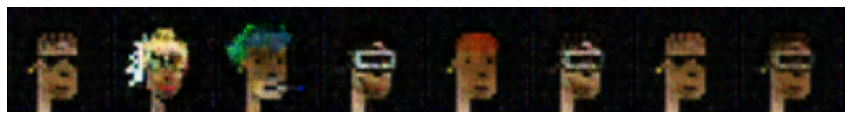

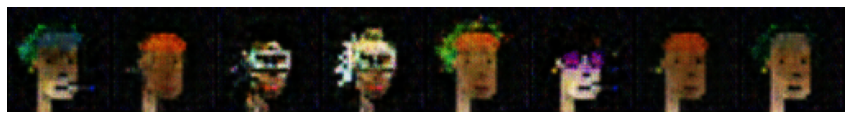

In [39]:
generator.to(device)
generator.eval() 
sample_size=8

for i in range(8):    
    
    fixed_z = Generator.get_noise(n_samples=sample_size, 
                                  z_dim=z_dim, 
                                  device=device)    
    
    sample_image = generator(fixed_z)
    print_tensor_images(sample_image)
